# DSE Course 1, Session 7: Product Quality Case Study Part 1

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will predict wine quality based on several chemical features. We will highlight key insights about our data being used in our predictive model: things like colinearity between features and feature skewness. For now we will stop at simply assessing the presence of these phenomenon in our data. In later sessions, we will apply strategies to improve our model in light of this phenomenon. 

<br>

---

<br>

<a name='top'></a>

# Contents

* 7.1 [Preparing Environment and Importing Data](#prepare)
  * 7.1.1 [Import Packages](#packages)
  * 7.1.2 [Load Dataset](#dataset)
* 7.2 [Exploratory Data Analysis (EDA)](#eda)
  * 7.2.1 [First Look: Shape, Nulls, Description](#first)
  * 7.2.2 [Descriptive Statistics](#statistics)
    * 7.2.2.1 [Statistics By Type](#type)
    * 7.2.2.2 [Statistcs By Quality](#quality)
  * 7.2.3 [Inferential Statistics](#infer) (ANOVA)
    * 7.2.3.1 [Inference of Feature by Wine Type](#inference1)
    * 7.2.3.2 [Inference of Feature by Quality Label](#inference2)
  * 7.2.4 [Feature Colinearity](#detectcolinearity)
* 7.3 [Feature Engineering](#engineering)
  * 7.3.1 [Feature Skewness](#skewness)
  * 7.3.2 [Feature Colinearity](#colinearity)
  * 7.3.3 [Feature Normalization](#normalization)
  * 7.3.4 [Feature Selection](#selection)
  * 7.4.5 [Dimensionality Reduction](#dimensionality)
* 7.4 [Modeling](#modeling)
  * 7.4.1 [Wine Type](#winetype)
  * 7.4.2 [Wine Quality](#winequality)

<br>

---


<a name="prepare"></a>
## 7.1 Preparing Environment and Importing Data
[back to top](#top)

<a name='packages'></a>
### 7.1.1 Import Packages
[back to top](#top)

Load libraries which will be needed in this Notebook



In [1]:
# Pandas library for the pandas dataframes
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats as stats
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



<a name='dataset'></a>
### 7.1.2 Load Dataset
[back to top](#top)


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

df['quality_label'] = df['quality'].apply(lambda x: 'low' if x <=5 else 
                                          'med' if x <= 7 else 'high')
df.columns = df.columns.str.replace(' ', '_')

<a name='eda'></a>
## 7.2 Exploratory Data Analysis (EDA)
[back to top](#top)

<a name='first'></a>
### 7.2.1 First Look: Shape, Nulls, Description
[back to top](#top)

In [5]:
df.shape

(6497, 14)

In [6]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df.isnull().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
quality_label            0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)
df['type_encoding'] = y_tp

class_ql = {'low':0, 'med': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)
df['quality_encoding'] = y_ql

<a name='statistics'></a>
### 7.2.2 Descriptive Statistics
[back to top](#top)

In [10]:
def desc(mydf, group=None, target=None):
  if group == None:
    skew = mydf.skew()
    kurt = mydf.kurtosis()
    pear = mydf.corr()['quality']
    spear = mydf.corr('spearman')['quality']
    null = mydf.isnull().sum()
    med = mydf.median()

    dff = pd.DataFrame([skew, kurt, pear, spear, null, med])
    dff = dff.T
    dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']
  else:
    dff = pd.DataFrame()
    for cat in mydf[group].unique():
      subdf = mydf.loc[mydf[group] == cat]
      subdf = subdf.drop([group],axis=1)
      skew = subdf.skew()
      kurt = subdf.kurtosis()
      pear = subdf.corr()['quality']
      spear = subdf.corr('spearman')['quality']
      null = subdf.isnull().sum()
      med = subdf.median()

      dfff = pd.DataFrame([skew, kurt, pear, spear, null, med])
      dfff = dfff.T
      dfff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']
      arrays = [[cat]*len(list(dfff.index)),list(dfff.index.values)]
      tuples = list(zip(*arrays))
      index = pd.MultiIndex.from_tuples(tuples, names=[group, "feature"])
      dfff.index = index
      dff = pd.concat([dff, dfff])
  return dff

<a name='type'></a>
#### 7.2.2.1 Statistics by Type
[back to top](#top)

In [11]:
desc(df, group='type')

skew   kurtosis  ...  null count      median
type  feature                                    ...                        
white fixed_acidity         0.644585   2.173205  ...         0.0    6.800000
      volatile_acidity      1.580874   5.148436  ...         0.0    0.260000
      citric_acid           1.292428   6.233045  ...         0.0    0.320000
      residual_sugar        1.078719   3.495918  ...         0.0    5.200000
      chlorides             5.033186  37.719886  ...         0.0    0.043000
      free_sulfur_dioxide   1.411447  11.513642  ...         0.0   34.000000
      total_sulfur_dioxide  0.392436   0.580726  ...         0.0  134.000000
      density               0.980642   9.824256  ...         0.0    0.993735
      pH                    0.463352   0.544051  ...         0.0    3.180000
      sulphates             0.982551   1.600887  ...         0.0    0.470000
      alcohol               0.484983  -0.701366  ...         0.0   10.400000
      quality               0.155094   0.218710  ...         0.0    6.000000
      type_encoding         0.000000   0.000000  ...         0.0    1.000000
      quality_encoding     -0.125266  -0.614522  ...         0.0    1.000000
      quality_label              NaN        NaN  ...         0.0         NaN
red   fixed_acidity         0.980441   1.130584  ...         0.0    7.900000
      volatile_acidity      0.673387   1.220743  ...         0.0    0.520000
      citric_acid           0.313999  -0.790386  ...         0.0    0.260000
      residual_sugar        4.537260  28.549070  ...         0.0    2.200000
      chlorides             5.674939  41.609076  ...         0.0    0.079000
      free_sulfur_dioxide   1.256757   2.069065  ...         0.0   14.000000
      total_sulfur_dioxide  1.516609   3.815485  ...         0.0   38.000000
      density               0.066754   0.937021  ...         0.0    0.996750
      pH                    0.197771   0.820555  ...         0.0    3.310000
      sulphates             2.432711  11.718472  ...         0.0    0.620000
      alcohol               0.866529   0.212027  ...         0.0   10.200000
      quality               0.221927   0.295728  ...         0.0    6.000000
      type_encoding         0.000000   0.000000  ...         0.0    0.000000
      quality_encoding      0.058656  -1.441290  ...         0.0    1.000000
      quality_label              NaN        NaN  ...         0.0         NaN

[30 rows x 6 columns]

<a name='quality'></a>
#### 7.2.2.2 Statistics by Quality
[back to top](#top)

In [12]:
desc(df, group='quality_label')

skew   kurtosis  ...  null count    median
quality_label feature                                    ...                      
med           fixed_acidity         1.796822   5.042419  ...         0.0    6.9000
              volatile_acidity      1.519565   2.752028  ...         0.0    0.2700
              citric_acid           0.685672   4.708707  ...         0.0    0.3100
              residual_sugar        1.697878   7.680155  ...         0.0    3.0000
              chlorides             4.439591  35.861062  ...         0.0    0.0450
              free_sulfur_dioxide   0.632236   0.589374  ...         0.0   29.0000
              total_sulfur_dioxide -0.058202  -0.444590  ...         0.0  116.0000
              density               0.991650  10.488941  ...         0.0    0.9940
              pH                    0.360759   0.432886  ...         0.0    3.2100
              sulphates             1.415138   5.683914  ...         0.0    0.5100
              alcohol               0.244318  -0.776750  ...         0.0   10.8000
              quality               1.003656  -0.993185  ...         0.0    6.0000
              type_encoding        -1.395817  -0.051723  ...         0.0    1.0000
              quality_encoding      0.000000   0.000000  ...         0.0    1.0000
              type                       NaN        NaN  ...         0.0       NaN
low           fixed_acidity         1.655246   5.253481  ...         0.0    7.1000
              volatile_acidity      1.251235   1.851378  ...         0.0    0.3375
              citric_acid           0.362612   0.289803  ...         0.0    0.2950
              residual_sugar        1.078420   0.117589  ...         0.0    2.9000
              chlorides             5.470290  46.002633  ...         0.0    0.0525
              free_sulfur_dioxide   1.795237  13.348635  ...         0.0   26.0000
              total_sulfur_dioxide  0.029223  -0.470669  ...         0.0  124.0000
              density              -0.189573  -0.311323  ...         0.0    0.9960
              pH                    0.458918   0.343719  ...         0.0    3.2000
              sulphates             2.657837  16.012168  ...         0.0    0.5000
              alcohol               1.168333   1.691425  ...         0.0    9.6000
              quality              -3.203327  10.249605  ...         0.0    5.0000
              type_encoding        -0.807964  -1.348332  ...         0.0    1.0000
              quality_encoding      0.000000   0.000000  ...         0.0    0.0000
              type                       NaN        NaN  ...         0.0       NaN
high          fixed_acidity         1.308021   4.824998  ...         0.0    6.8000
              volatile_acidity      1.198787   2.526275  ...         0.0    0.2700
              citric_acid           0.536103   3.042666  ...         0.0    0.3200
              residual_sugar        0.975625  -0.242299  ...         0.0    4.1000
              chlorides             1.950042   6.245808  ...         0.0    0.0370
              free_sulfur_dioxide   1.136000   3.251076  ...         0.0   34.0000
              total_sulfur_dioxide -0.345481   0.613629  ...         0.0  119.0000
              density               0.927227   0.192507  ...         0.0    0.9918
              pH                    0.172560  -0.120983  ...         0.0    3.2300
              sulphates             0.861804   0.283189  ...         0.0    0.4800
              alcohol              -0.856611   0.122386  ...         0.0   12.0000
              quality               6.081806  35.347127  ...         0.0    8.0000
              type_encoding        -2.858180   6.232368  ...         0.0    1.0000
              quality_encoding      0.000000   0.000000  ...         0.0    2.0000
              type                       NaN        NaN  ...         0.0       NaN

[45 rows x 6 columns]

<a name='infer'></a>
### Inferential Statistics

[back to top](#top)

<a name='inference1'></a>
#### 7.2.3.1 Inference of Feature by Wine Type
[back to top](#top)

In [26]:
def type_inf_feature_test(df, feature):
    F, p = f_oneway(df.loc[df.type == 'red'][feature], 
                    df.loc[df.type == 'white'][feature])
    m1, m2 = df.loc[df.type == 'red'][feature].median(), \
                    df.loc[df.type == 'white'][feature].median()
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print(feature)
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    print('group medians: {:.2f} (red), {:.2f} (white)\n'.format(m1,m2))

In [33]:
features = list(df.columns[1:-1].values)
features.remove('type_encoding')
features.remove('quality_label')

In [30]:
print('ANOVA test for features from red and white wines:\n')
for feature in features:
  type_inf_feature_test(df, feature)

ANOVA test for features from red and white wines:

fixed_acidity
F Statistic: 2025.60 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 7.90 (red), 6.80 (white)

volatile_acidity
F Statistic: 4812.72 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.52 (red), 0.26 (white)

citric_acid
F Statistic: 231.26 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.26 (red), 0.32 (white)

residual_sugar
F Statistic: 898.19 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 2.20 (red), 5.20 (white)

chlorides
F Statistic: 2304.04 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.08 (red), 0.04 (white)

free_sulfur_dioxide
F Statistic: 1858.61 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 14.00 (red), 34.00 (white)

total_sulfur_dioxide
F Statistic: 6225.78 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 38.00 (red), 134.00 (white)

density
F Statistic: 1169.11 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 1.00 (red), 0.99 (white)

pH
F 

<a name='inference2'></a>
#### 7.2.3.2 Inference of Feature by Quality Label
[back to top](#top)

In [34]:
def quality_inf_feature_test(df, feature):
    F, p = f_oneway(df.loc[df['quality_label'] == 'low'][feature], 
                    df.loc[df['quality_label'] == 'med'][feature],
                    df.loc[df['quality_label'] == 'high'][feature])
    m1, m2, m3 = df.loc[df['quality_label'] == 'low'][feature].median(), \
             df.loc[df['quality_label'] == 'med'][feature].median(), \
             df.loc[df['quality_label'] == 'high'][feature].median()
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print(feature)
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    print('group medians: {:.2f} (low), {:.2f} (medium), {:.2f} (high)\n'.format(m1,m2,m3))

In [40]:
print('ANOVA test for features from high, medium, and low quality wines:\n')
for feature in features:
  quality_inf_feature_test(df, feature)

ANOVA test for features from high, medium, and low quality wines:

fixed_acidity
F Statistic: 20.09 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 7.10 (low), 6.90 (medium), 6.80 (high)

volatile_acidity
F Statistic: 251.32 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.34 (low), 0.27 (medium), 0.27 (high)

citric_acid
F Statistic: 18.67 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.29 (low), 0.31 (medium), 0.32 (high)

residual_sugar
F Statistic: 2.94 	p-value: 0.053 	Null Hypothesis: Accept
group medians: 2.90 (low), 3.00 (medium), 4.10 (high)

chlorides
F Statistic: 120.76 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.05 (low), 0.04 (medium), 0.04 (high)

free_sulfur_dioxide
F Statistic: 10.22 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 26.00 (low), 29.00 (medium), 34.00 (high)

total_sulfur_dioxide
F Statistic: 7.80 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 124.00 (low), 116.00 (medium), 119.00 (high)

density
F 

<a name='detectcolinearity'></a>
### 7.2.4 Feature Colinearity
[back to top](#top)

In [41]:
# in order to compare with wine type we will need to turn the string/category
# column into a binary mapping
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(df.type.values) # 1 - White; 0 - Red
df['color'] = y_tp

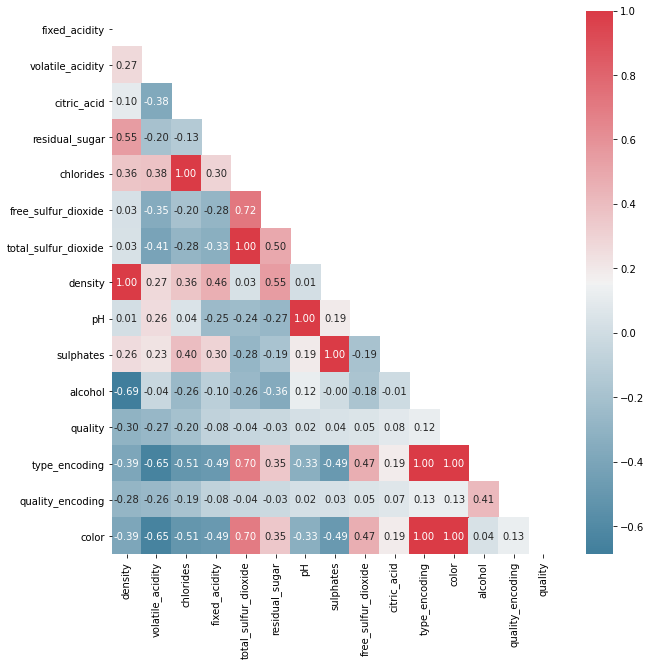

In [42]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize = (10,10))

# create a mask to white-out the upper triangle
mask = np.triu(np.ones_like(df.corr().sort_values(by=['quality'], axis=1),
                            dtype=bool))

# we'll want a divergent colormap for this so our eye
# is not attracted to the values close to 0
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(df.corr().sort_values(by=['quality'], axis=1), mask=mask, cmap=cmap,
            ax=ax, annot=True, fmt=".2f")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



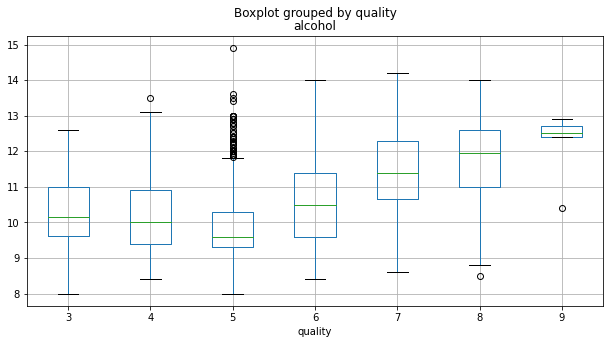

In [43]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.boxplot(column='alcohol', by='quality', ax=ax)

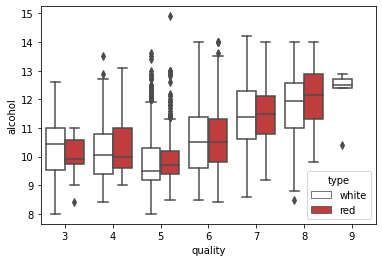

In [44]:
sns.boxplot(x='quality', y='alcohol', hue='type', data=df, 
            palette={"red": "tab:red", "white": "white"})

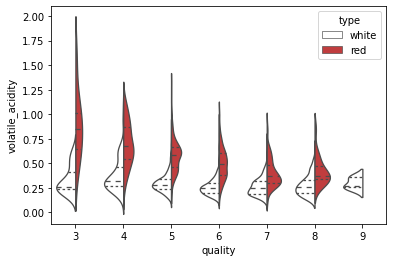

In [45]:
sns.violinplot(x='quality', y='volatile_acidity', hue='type', data=df, 
               split=True, inner='quart', linewidth=1.3,
               palette={'red': 'tab:red', 'white': 'white'})

<a name='engineering'></a>
## 7.3 Feature Engineering
[back to top](#top)

<a name='skewness'></a>
### 7.3.1 Feature Skewness
[back to top](#top)

**Model bias and spurious interactions**: When performing a regression or any statistical modeling, asymmetrical behavior may lead to a bias in the model. In this course, we won't cover the more advanced methods of dealing with skewness (we are covering this in course 2) but we would like to make a nod to it here. 

One method to deal with skewness is to normalize using a Box-Cox transformation. methods to detect it is the skewness factor we calculated directly in pandas [above](#type) or plotting the QQ factor.

<a name='colinearity'></a>
### 7.3.3 Feature Colinearity
[back to top](#top)

We began to touch on feature colinearity when we calculated the **pearsons correlation** between variables [above](#detectcolinearity).

The **Variance Inflation Factor (VIF)** is a measure of collinearity among predictor variables within a multiple regression. It is may be calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the R2 from that regression.

Generally, we could run the same model twice, once with severe multicollinearity and once with moderate multicollinearity. This provides a great head-to-head comparison and it reveals the classic effects of multicollinearity. However, when standardizing your predictors doesn't work, you can try other solutions such as:

* removing highly correlated predictors
* linearly combining predictors, such as adding them together
* running entirely different analyses, such as partial least squares regression or principal components analysis

Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :

$$VIF=\frac{1}{1-R^2}$$

Where, R-squared is the coefficient of determination in linear regression. Its value lies between 0 and 1.

> How does a higher R2 effect colinearity?

In [46]:
def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    dff = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    dff[predict] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = dff, 
                     return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in 
                         range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    vif['Recommendation'] = vif['VIF Factor'].apply(lambda x: 'Drop' 
                                                    if x > 5 else 'Keep')
    display(vif.sort_values('VIF Factor'))
    return vif

cols = df.columns.str.replace(' ', '_')
dff = df.copy()
dff.columns = cols

class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)

cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', dff.loc[:, cols], y_ql)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



,VIF Factor,features,Recommendation
13,1.405220,quality_encoding,Keep
5,1.637966,chlorides,Keep
10,1.641158,sulphates,Keep
3,1.694275,citric_acid,Keep
0,1.962019,Intercept,Keep
2,2.266395,volatile_acidity,Keep
6,2.407546,free_sulfur_dioxide,Keep
9,2.968710,pH,Keep
7,4.267897,total_sulfur_dioxide,Keep
11,5.118782,alcohol,Drop


In [47]:
vif = VRF('type', dff.loc[:, cols], y_tp)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning:

divide by zero encountered in double_scalars



,VIF Factor,features,Recommendation
0,1.000000,Intercept,Keep
13,1.352986,quality_encoding,Keep
10,1.569455,sulphates,Keep
3,1.622486,citric_acid,Keep
5,1.659647,chlorides,Keep
6,2.254296,free_sulfur_dioxide,Keep
2,2.273188,volatile_acidity,Keep
9,2.568082,pH,Keep
7,4.070062,total_sulfur_dioxide,Keep
1,5.071376,fixed_acidity,Drop


<a name='normalization'></a>
### 7.3.2 Feature Normalization
[back to top](#top)

<a name='selection'></a>
### 7.3.4 Feature Selection
[back to top](#top)

<a name='dimensionality'></a>
### 7.3.5 Dimensionality Reduction
[back to top](#top)

<a name='modeling'></a>
## 7.4 Modeling
[back to top](#top)

First we will make some support functions help us evaluate ours models through a standard. Next, we proceed with the classifications of wines types and next of wines quality labels. We will finalize our quality classification model with a staking approach.

<a name='winetype'></a>
### 7.4.1 Wine Type
[back to top](#top)

Since it is a binary classification task, we try first with a simple logistic regression.

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle both dense and sparse input.

In [48]:
cols = df.columns
cols = list(cols.drop(['type', 'type_encoding', 'quality', 'quality_encoding', 
                       'quality_label']))
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, cols], y_tp,
                                      test_size=0.20, random_state=42)

In [49]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

In [50]:
model.fit(X_train, y_train)

LogisticRegression(C=0.003, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000.0, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='sag', tol=0.001,
                   verbose=0, warm_start=False)

In [51]:
y_pred = model.predict(X_test)

In [52]:
print("Accuracy: {:.2f}".format((len(y_pred)-np.sum(np.abs(y_test-y_pred)))/len(y_pred)))

Accuracy: 0.95


In [53]:
true_labels = y_test
predicted_labels = y_pred

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))

Accuracy:  95.44% 
Precision: 95.57% 
Recall:    95.44% 
F1 Score:  95.48% 


In [55]:
target_names = ['red', 'white']
total_classes = len(target_names)
level_labels = [total_classes*[0], list(range(total_classes))]
cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

In [ ]:
pd.MultiIndex()

In [58]:
cm_frame = pd.DataFrame(data=cm, 
                        columns=pd.MultiIndex(levels=[['Predicted:'], target_names], codes=level_labels), 
                        index=pd.MultiIndex(levels=[['Actual:'], target_names], codes=level_labels)) 
print(cm_frame) 

              Predicted:      
                     red white
Actual: red          302    20
        white         39   932


<a name='winequality'></a>
### 7.4.2 Wine Quality
[back to top](#top)

In [ ]:
def get_results(model, name, data, true_labels, target_names = ['red', 'white'], results=None, reasume=False):
  
    if hasattr(model, 'layers'):
        param = wtp_dnn_model.history.params
        best = np.mean(wtp_dnn_model.history.history['val_acc'])
        predicted_labels = model.predict_classes(data) 
        im_model = InMemoryModel(model.predict, examples=data, target_names=target_names)

    else:
        param = gs.best_params_
        best = gs.best_score_
        predicted_labels = model.predict(data).ravel()
        if hasattr(model, 'predict_proba'):
            im_model = InMemoryModel(model.predict_proba, examples=data, target_names=target_names)
        elif hasattr(clf, 'decision_function'):
            im_model = InMemoryModel(model.decision_function, examples=data, target_names=target_names)
        
    print('Mean Best Accuracy: {:2.2%}'.format(best))
    print('-'*60)
    print('Best Parameters:')
    print(param)
    print('-'*60)
    
    y_pred = model.predict(data).ravel()
    
    display_model_performance_metrics(true_labels, predicted_labels = predicted_labels, target_names = target_names)
    if len(target_names)==2:
        ras = roc_auc_score(y_true=true_labels, y_score=y_pred)
    else:
        roc_auc_multiclass, ras = roc_auc_score_multiclass(y_true=true_labels, y_score=y_pred, target_names=target_names)
        print('\nROC AUC Score by Classes:\n',roc_auc_multiclass)
        print('-'*60)

    print('\n\n              ROC AUC Score: {:2.2%}'.format(ras))
    prob, score_roc, roc_auc = plot_model_roc_curve(model, data, true_labels, label_encoder=None, class_names=target_names)
    
    interpreter = Interpretation(data, feature_names=cols)
    plots = interpreter.feature_importance.plot_feature_importance(im_model, progressbar=False, n_jobs=1, ascending=True)
    
    r1 = pd.DataFrame([(prob, best, np.round(accuracy_score(true_labels, predicted_labels), 4), 
                         ras, roc_auc)], index = [name],
                         columns = ['Prob', 'CV Accuracy', 'Accuracy', 'ROC AUC Score', 'ROC Area'])
    if reasume:
        results = r1
    elif (name in results.index):        
        results.loc[[name], :] = r1
    else: 
        results = results.append(r1)
        
    return results

def roc_auc_score_multiclass(y_true, y_score, target_names, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(y_true)
  roc_auc_dict = {}
  mean_roc_auc = 0
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_y_true = [0 if x in other_class else 1 for x in y_true]
    new_y_score = [0 if x in other_class else 1 for x in y_score]
    num_new_y_true = sum(new_y_true)

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_y_true, new_y_score, average = average)
    roc_auc_dict[target_names[per_class]] = np.round(roc_auc, 4)
    mean_roc_auc += num_new_y_true * np.round(roc_auc, 4)
    
  mean_roc_auc = mean_roc_auc/len(y_true)  
  return roc_auc_dict, mean_roc_auc

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        

def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, target_names):
    
    total_classes = len(target_names)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], target_names], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], target_names], labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, target_names):

    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
   
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prb = clf.predict_proba(features)
            if prb.shape[1] > 1:
                y_score = prb[:, prb.shape[1]-1] 
            else:
                y_score = clf.predict(features).ravel()
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(true_labels, y_score)      
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = {0:3.2%})'.format(roc_auc), linewidth=2.5)
        
    elif n_classes > 2:
        if  hasattr(clf, 'clfs_'):
            y_labels = label_binarize(true_labels, classes=list(range(len(class_labels))))
        else:
            y_labels = label_binarize(true_labels, classes=class_labels)
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
            
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_labels.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_names):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:2.2%})'
                                           ''.format(label, roc_auc[i]), linewidth=2, linestyle=':')
        roc_auc = roc_auc["macro"]   
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return prob, y_score, roc_auc